<a href="https://colab.research.google.com/github/TheAnders121/TestRepo/blob/main/ProjektKode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import libraries**

In [2]:
import os
import datetime
import time

from datetime import datetime, timedelta
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

import json
import requests
import pickle



**Configurations**

In [ ]:
#Paths
model_path = '/content/saved_model/my_model'
historical_data = 'data.csv'
rData_path = 'input.csv'
log_path = 'log.txt'

#Model columns
direct = 'DirectSunPower kW/m²'
diffused = 'DiffuseSunPower kW/m²'
sunAltitude = 'SunAltitude °'
inputColumn = sunAltitude
outputColumn = diffused

#Model construction
steps = 24
inputColumns = 2
inputShape = [steps, inputColumns]

#Model compilation, fitting and optimization
optimizationAlgorithm = tf.keras.optimizers.Adam()
patience = 2
conf_epochs = 60
lag = 24
n_ahead = 4
model_units = 32
activation_function = 'sigmoid'
conf_batch_size = 24


**Split data**

In [1]:
#Split data into training and validation data sets 
def split_data(data):
  n = len(data)
  train = data[0:int(n*0.9)] #first 90%
  test = data[int(n*0.9):] #left over 10%
  return train, test

**To json string**

In [ ]:
#Convert string to json string
def toJson(string):
  return json.dumps(string)

**Compile**

In [ ]:
#Compile model 
def compile(model, patience=2):

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=optimizationAlgorithm,
                metrics=[tf.keras.metrics.MeanAbsoluteError(),
                         tf.keras.metrics.MeanSquaredError(),
                         tf.keras.metrics.RootMeanSquaredError()])
  return model

**Fit model**

In [3]:
#Fit model
#model - given model that is to be fitted 
#input - fit model with given input 
#output - expected output with given input
def fit(model, input, output):
  callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
  history = model.fit(
    input, output,
    epochs=conf_epochs,
    batch_size=conf_batch_size,
    callbacks=[callback],
    validation_split=0.1,
    shuffle=False
  )
  return history

**Save model**

In [ ]:
#model - model that is to be saved (needs to be a tf.keras.model object)
#path - under which path the model will be saved (and can be accessed)
def save_model(model, path):
  model.save(path)

**Load model**

In [ ]:
#path - under which path the model will be accessible
def load_model(path):
  new_model = tf.keras.models.load_model(path)

  return new_model

**Load data**

In [ ]:
#path - path to where the data is to be loaded from 
def load_data(path):
  dt = pd.read_csv(path, sep=";",thousands='.', decimal=',') #read csv file with ';' as seperator and ',' as decimal marker (will be converted to '.')
  return dt

**Process data**

In [ ]:
#data - data that is to be processed in order for the model to read it
def process_data(data):
  # Convert to radians.
  data[sunAltitude] = data[sunAltitude]*np.pi / 180
  return data

**Remove impossible values**

In [ ]:
#Replaces all negative values with 0, since negative power values don't exist in this context
def remove_negative(data):
  data[data < 0] = 0
  return data

**Predict**

In [ ]:
#data - 48 datapoints for the model to predict the next 24 datapoints
def make_prediction(model, data, plot):
  if plot == False:
    prediction = model.predict(data)
    return prediction
  #Code to return plot 


**Shape data for model**

In [ ]:
#! Code snippet Ana Turk !
#Shapes data to be model compatible
def create_X_Y(ts: np.array, lag=1, n_ahead=1, target_index=0) -> tuple:

 n_features = ts.shape[1]

 X, Y = [], []
 if len(ts) - lag <= 0:
  X.append(ts)
 else:
  for i in range(len(ts) - lag - n_ahead):
    Y.append(ts[(i + lag):(i + lag + n_ahead), target_index])
    X.append(ts[i:(i + lag)])

 X, Y = np.array(X), np.array(Y)
 # Reshaping the X array to an GRU input shape
 X = np.reshape(X, (X.shape[0], lag, n_features)) 
 return X, Y

**Model construction**

In [ ]:
#Constructs model from scratch
def construct_model():

  #Load data
  data = load_data(historical_data)

  #Isolate data
  data = data[[inputColumn, outputColumn]].copy()

  #Process data columns
  data = process_data(data)

  # shift column 'Name' to first position
  first_column = data.pop(outputColumn)
    
  # insert column using insert(position,column_name,
  # first_column) function
  data.insert(0, outputColumn, first_column)

  #Split data
  train, test = split_data(data)

  #Transform data 
  inputTransformer = MinMaxScaler()
  outputTransformer = MinMaxScaler()

  #Train data
  inputTransformer = inputTransformer.fit(train)
  outputTransformer = outputTransformer.fit(train[[outputColumn]])

  norm_train = inputTransformer.transform(train)
  norm_train_Y = outputTransformer.transform(train[[outputColumn]])

  #Test data
  inputTransformer = inputTransformer.fit(test)
  outputTransformer = outputTransformer.fit(test[[outputColumn]])

  norm_test = inputTransformer.transform(test)
  norm_test_Y = outputTransformer.transform(test[[outputColumn]])

  #Create datasets
  train_X, train_Y = create_X_Y(norm_train, lag=lag, n_ahead=n_ahead)
  test_X, test_Y = create_X_Y(norm_test, lag=lag, n_ahead=n_ahead)

  #Model building
  model = keras.Sequential()

  model.add(keras.layers.GRU(units=model_units,
                input_shape=(lag, 2),
                activation=activation_function)
          )
  model.add(keras.layers.Dropout(rate=0.2))
  model.add(keras.layers.Dense(units=n_ahead))

  #Compile model
  model = compile(model)

  #Fit model
  history = fit(model, train_X, train_Y)

  #Make prediction
  prediction = make_prediction(model, test_X, False)

  #Inverse transform data
  predictionInverse = outputTransformer.inverse_transform(prediction)
  outputTestInv = outputTransformer.inverse_transform(test_Y)

  predictionInverse = remove_negative(predictionInverse)

  #Record performance of predictions
  with open(log_path, 'a') as f:
    mae = mean_absolute_error( test_Y, prediction)
    mse = mean_squared_error( test_Y, prediction)
    rmse = mean_squared_error(test_Y, prediction, squared=False) #Squared false return RMSE
    r2 = r2_score(test_Y , prediction)
    mape = mean_absolute_percentage_error(test_Y, prediction)
    me = np.mean(prediction - test_Y)
    f.write(datetime.now().strftime("%d.%b %Y %H:%M:%S: "))
    f.write("Test performance results:")
    f.write(f"\nMAE: {mae}")
    f.write(f"\nMSE:{mse}")
    f.write(f"\nRMSE: {rmse}")
    f.write(f"\nR-Squared: {r2}")
    f.write(f"\nMAPE: {mape}")
    f.write(f"\nME: {me}")

  #Save model
  save_model(model, model_path)

  return model


** Main **

Epoch 1/60
202/202 [==============================] - 5s 15ms/step - loss: 0.0516 - mean_absolute_error: 0.1735 - accuracy: 0.0000e+00 - mean_absolute_percentage_error: 97867000.0000 - mean_squared_error: 0.0516 - root_mean_squared_error: 0.2272 - val_loss: 0.0767 - val_mean_absolute_error: 0.2079 - val_accuracy: 0.0000e+00 - val_mean_absolute_percentage_error: 49323416.0000 - val_mean_squared_error: 0.0767 - val_root_mean_squared_error: 0.2770
Epoch 2/60
202/202 [==============================] - 3s 13ms/step - loss: 0.0262 - mean_absolute_error: 0.1222 - accuracy: 0.0000e+00 - mean_absolute_percentage_error: 61676356.0000 - mean_squared_error: 0.0262 - root_mean_squared_error: 0.1619 - val_loss: 0.0644 - val_mean_absolute_error: 0.1912 - val_accuracy: 0.0000e+00 - val_mean_absolute_percentage_error: 49042076.0000 - val_mean_squared_error: 0.0644 - val_root_mean_squared_error: 0.2539
Epoch 3/60
202/202 [==============================] - 3s 13ms/step - loss: 0.0218 - mean_absolute_erro

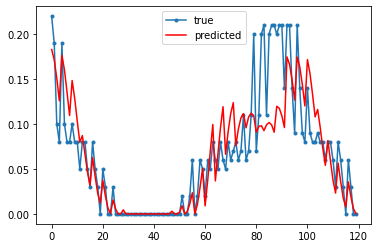

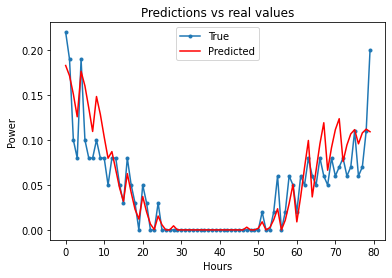

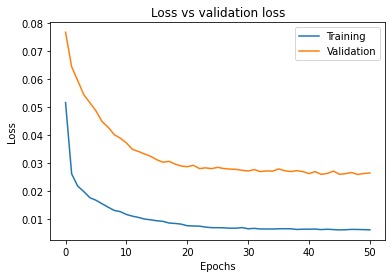

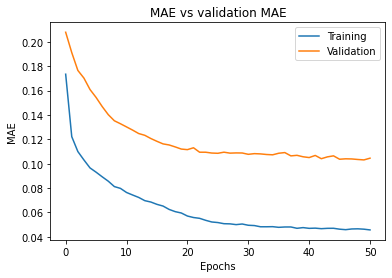

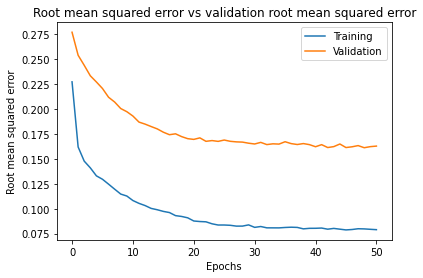

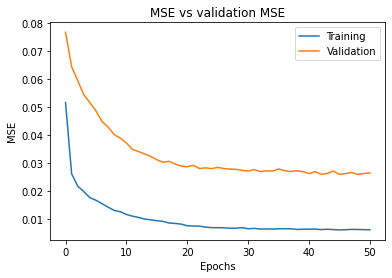

In [ ]:
#Main function
with open(log_path, 'a') as f:

    if os.path.exists(model_path):
      f.write(datetime.now().strftime("%d.%b %Y %H:%M:%S: "))
      f.write("Loading model\n")
      model = load_model(model_path) 
    else:
      f.write(datetime.now().strftime("%d.%b %Y %H:%M:%S: "))
      f.write('Model could not be loaded\n')

      f.write(datetime.now().strftime("%d.%b %Y %H:%M:%S: "))
      f.write('Constructing new model\n')
      try:
        model = construct_model()
      except:
        f.write(datetime.now().strftime("%d.%b %Y %H:%M:%S: "))
        f.write('Model could be not constructed\n')

        f.write(datetime.now().strftime("%d.%b %Y %H:%M:%S: "))
        f.write('Exitting program\n')

        #Exit program
        print("Model could be not constructed")
        print("Exitting program")
        raise SystemExit

#Process data
data = load_data(rData_path)
data = data[[inputColumn, outputColumn]].copy()
data = process_data(data) 

#Transform data
inputTransformer = MinMaxScaler()
outputTransformer = MinMaxScaler()
inputTransformer = inputTransformer.fit(data)
outputTransformer = outputTransformer.fit(data[[outputColumn]])
scaled_data = inputTransformer.transform(data)

#Creates data datasets
data_X, data_Y = create_X_Y(scaled_data, lag=lag, n_ahead=n_ahead)

#Predictions
scaled_predictions = make_prediction(model, data_X, False)
predictions = outputTransformer.inverse_transform(scaled_predictions)
predictions = remove_negative(predictions)
jsonPredictions = toJson(predictions.tolist())

#Json string of prediction
print(jsonPredictions)
with open(log_path, 'a') as f:
  f.write(datetime.now().strftime("%d.%b %Y %H:%M:%S: "))
  f.write(f"Predictions made: {predictions}\n")